In [1]:
import os

os.environ["MODIN_ENGINE"] = "ray" 

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from IPython.display import display

In [2]:
data_path='dataset/sudoku.csv'
full_df=pd.read_csv(data_path)
print(full_df.shape)
display(full_df.head())

(1000000, 2)


,quizzes,solutions
0,0043002090050090010700600430060020871900074000...,8643712593258497619712658434361925871986574322...
1,0401000501070039605200080000000000170009068008...,3461792581875239645296483719658324174729168358...
2,6001203840084590720000060050002640300700800069...,6951273841384596727248369158512647392739815469...
3,4972000001004000050000160986203000403009000000...,4972583161864397252537164986293815473759641828...
4,0059103080094030600275001000300002010008200070...,4659123781894735623275681497386452919548216372...


In [3]:
df = full_df[:2000]

In [121]:
class MyDataGenerator(Sequence):
    def __init__(self, X, y, batch_size=32, dim=(81,), n_channels=1, n_classes=9, shuffle=False):
        self.dim=dim
        self.batch_size=batch_size
        self.n_channels=n_channels
        self.n_classes=n_classes
        self.shuffle=shuffle
        self.X=self.__convert_to_array(X)
        self.y=self.__convert_to_array(y)
        self.on_epoch_end()
        
    def __convert_to_array(self, series):
        """Convert the input string of 81 integers into a integer array
        paramd: series: a pandas.Series of shape(-, 1) containing a string of 81 numbers,
        ret: numpy.ndarray of shape (-1, 81) type=int"""
        ret_ser = []
        no_of_ex = series.shape[0]
        for i in range(no_of_ex):
            str_ = str(series.loc[i])
            ret_ser.append([float(s) for s in str_])
        
        if len(ret_ser) == 1:  #handling data if only 1 row present
            ret_ser = np.array([ret_ser])
        else:
            ret_ser = np.array(ret_ser)
        display(ret_ser)
        print(ret_ser.shape)
        return ret_ser
        
    def __data_generator(self, X, y):
        """Takes input X and y and generates incomplete sudoku quizes with 1 input put in place at a time
        So if 1 quiz has 5 empty places then it will generate a list of 5 quizes with 1 input put in right place at each itteration
        param: X: numpy.ndarray of shape (-1, 81)
               y: numpy.ndarray of shape (-1, 81)
        ret:   ret_X: numpy.ndarray of shape(-1, 81)
               ret_y: numpy.ndarray of shape(-1, 9)"""
        ret_X=[]
        ret_y=[]
        for i in range(X.shape[0]):
            for j in range(81):
                if X[i][j] == 0:
                    ret_X.append(X[i].copy())
                    temp_y = np.zeros((9))
                    temp_y[int(y[i][j])-1]=1
                    ret_y.append(temp_y)
                    X[i][j]=y[i][j]
        ret_X = np.array(ret_X)
        ret_y = np.array(ret_y, dtype=int)
        return ret_X, ret_y
    
    def __len__(self):
        """Returns the no of examples in each batch
        ret: int"""
        return int(np.ceil(len(self.X)/self.batch_size))
    
    def __getitem__(self, index):
        """Generates a batch for the given index
        param: index: the batch no of the batch to be provided for the current epoch
        ret:   ret_X: generated set of incomplete quizes of shape (-1, 81)
               ret_y: the logit has to be inserted for each incomplete quiz of shape (-1, 9)"""
        Xs=np.array(self.X[index*self.batch_size: (index+1)*self.batch_size])
        ys=np.array(self.y[index*self.batch_size: (index+1)*self.batch_size])
        return self.__data_generator(Xs,ys)

In [122]:
batch_size=128

In [123]:
X=df['quizzes']
y=df['solutions']
print(X.shape)
print(y.shape)

(2000,)
(2000,)


In [124]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.05, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(X_eval.shape)
print(y_eval.shape)

(1900,)
(1900,)
(100,)
(100,)


In [125]:
X[0:3].shape

(3,)

In [126]:
my_data_generator=MyDataGenerator(X_train, y_train, batch_size=batch_size)

array([[0., 0., 4., ..., 3., 0., 0.],
       [0., 4., 0., ..., 1., 0., 0.],
       [6., 0., 0., ..., 1., 9., 0.],
       ...,
       [0., 6., 0., ..., 0., 0., 9.],
       [7., 0., 0., ..., 0., 0., 0.],
       [0., 0., 4., ..., 0., 8., 0.]])

(1900, 81)


array([[8., 6., 4., ..., 3., 7., 8.],
       [3., 4., 6., ..., 1., 8., 6.],
       [6., 9., 5., ..., 1., 9., 7.],
       ...,
       [2., 6., 8., ..., 8., 7., 9.],
       [7., 1., 9., ..., 6., 1., 4.],
       [7., 8., 4., ..., 4., 8., 7.]])

(1900, 81)


In [127]:
model = Sequential()
model.add(Dense(81, name='Hidden_layer_1', activation='relu', kernel_initializer='normal', input_dim=81))
model.add(Dense(81, name='Hidden_layer_2', activation='relu', kernel_initializer='normal'))
model.add(Dense(27, name='Hidden_layer_3', activation='relu', kernel_initializer='normal'))
model.add(Dense(9, name='output_layer', activation='sigmoid'))

In [128]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_layer_1 (Dense)       (None, 81)                6642      
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 81)                6642      
_________________________________________________________________
Hidden_layer_3 (Dense)       (None, 27)                2214      
_________________________________________________________________
output_layer (Dense)         (None, 9)                 252       
Total params: 15,750
Trainable params: 15,750
Non-trainable params: 0
_________________________________________________________________


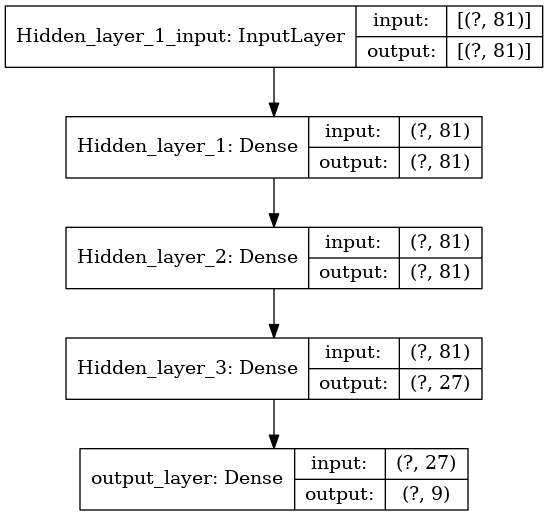

In [129]:
plot_model(model, 'model_with_data_generator.png', show_shapes=True)

In [130]:
optimizer = RMSprop(learning_rate=0.5, momentum=0.5)

In [131]:
model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [132]:
history=model.fit(my_data_generator, batch_size=batch_size, epochs=50, verbose=1)

Epoch 1/50
15/15 [==============================] - 2s 112ms/step - loss: 2.1975 - accuracy: 0.1125
Epoch 2/50
15/15 [==============================] - 2s 113ms/step - loss: 2.1971 - accuracy: 0.1122
Epoch 3/50
15/15 [==============================] - 1s 98ms/step - loss: 2.1970 - accuracy: 0.1139
Epoch 4/50
15/15 [==============================] - 2s 108ms/step - loss: 2.1967 - accuracy: 0.1160
Epoch 5/50
15/15 [==============================] - 2s 116ms/step - loss: 2.1964 - accuracy: 0.1162
Epoch 6/50
15/15 [==============================] - 2s 110ms/step - loss: 2.1961 - accuracy: 0.1200
Epoch 7/50
15/15 [==============================] - 2s 112ms/step - loss: 2.1957 - accuracy: 0.1200
Epoch 8/50
15/15 [==============================] - 2s 112ms/step - loss: 2.1952 - accuracy: 0.1220
Epoch 9/50
15/15 [==============================] - 2s 117ms/step - loss: 2.1948 - accuracy: 0.1226
Epoch 10/50
15/15 [==============================] - 2s 129ms/step - loss: 2.1942 - accuracy: 0.1239


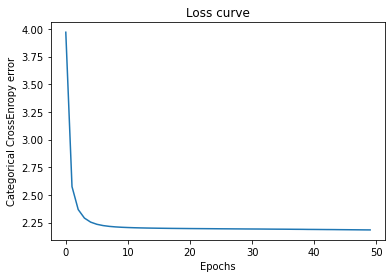

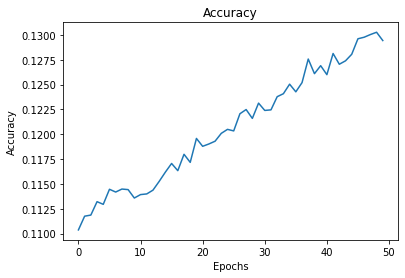

In [42]:
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Categorical CrossEnropy error')
plt.plot(history.history['loss'])
plt.show()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'])
plt.show()

#print(history.history)

In [30]:
eval_generator=MyDataGenerator(X_eval[:3], y_eval[:3], batch_size=batch_size)

(3, 81)
(3, 81)


In [31]:
model.evaluate(eval_generator, batch_size=batch_size, verbose=1)

range(0, 32)

working on 0th example
[[0 2 9 0 0 0 5 8 0]
 [6 0 0 3 2 0 4 0 7]
 [1 0 0 8 0 0 0 0 0]
 [0 0 0 0 6 0 3 0 1]
 [0 7 1 0 0 4 0 6 0]
 [0 0 0 2 3 0 0 9 0]
 [0 0 4 6 5 0 0 0 9]
 [7 8 3 0 1 0 0 0 5]
 [5 9 0 0 0 0 0 7 2]]
0th element is 0
3th element is 0
4th element is 0
5th element is 0
8th element is 0
10th element is 0
11th element is 0
14th element is 0
16th element is 0
19th element is 0
20th element is 0
22th element is 0
23th element is 0
24th element is 0
25th element is 0
26th element is 0
27th element is 0
28th element is 0
29th element is 0
30th element is 0
32th element is 0
34th element is 0
36th element is 0
39th element is 0
40th element is 0
42th element is 0
44th element is 0
45th element is 0
46th element is 0
47th element is 0
50th element is 0
51th element is 0
53th element is 0
54th element is 0
55th element is 0
59th element is 0
60th element is 0
61th element is 0
66th element is 0
68th element is 0
69th element is 0
70th element is 0
74th element is 0
75th

[9.341645240783691, 0.11347517371177673]

In [33]:
ex_idx = 0

In [40]:
type(X)

modin.pandas.series.Series

In [42]:
print(X.loc[ex_idx])
print(type(X.loc[ex_idx]))

004300209005009001070060043006002087190007400050083000600000105003508690042910300
<class 'str'>


In [35]:
print(y[ex_idx])

864371259325849761971265843436192587198657432257483916689734125713528694542916378


In [43]:
solv = X[ex_idx]
print(solv)

004300209005009001070060043006002087190007400050083000600000105003508690042910300


In [50]:
class PredictionGenerator(Sequence):
    def __init__(self, X, batch_size=32, dim=(81,), n_channels=1, n_classes=9, shuffle=False):
        self.dim=dim
        self.batch_size=batch_size
        self.n_channels=n_channels
        self.n_classes=n_classes
        self.shuffle=shuffle
        self.X=self.__convert_to_array(X)
        self.on_epoch_end()
        
    def __convert_to_array(self, x):
        ret_ser = np.zeros((1, 81), dtype=int)
        ret_ser[0] = [int(s) for s in x]
        print(ret_ser.shape)
        return ret_ser
        
        
    
    def __len__(self):
        return 1
    
    def __getitem__(self, i):
        return self.X

In [51]:
my_predictor=PredictionGenerator(solv)

(1, 81)


In [55]:
solution=np.array([int(s) for s in solv])
print(solution.reshape((9,9)))
print(solution.shape)

[[0 0 4 3 0 0 2 0 9]
 [0 0 5 0 0 9 0 0 1]
 [0 7 0 0 6 0 0 4 3]
 [0 0 6 0 0 2 0 8 7]
 [1 9 0 0 0 7 4 0 0]
 [0 5 0 0 8 3 0 0 0]
 [6 0 0 0 0 0 1 0 5]
 [0 0 3 5 0 8 6 9 0]
 [0 4 2 9 1 0 3 0 0]]
(81,)


In [56]:
for i,x in enumerate(solv):
    if int(x)==0:
        s = model.predict_classes(my_predictor)
        solution[i]=s+1
print(solution.reshape((9,9)))

[[7 7 4 3 7 7 2 7 9]
 [7 7 5 7 7 9 7 7 1]
 [7 7 7 7 6 7 7 4 3]
 [7 7 6 7 7 2 7 8 7]
 [1 9 7 7 7 7 4 7 7]
 [7 5 7 7 8 3 7 7 7]
 [6 7 7 7 7 7 1 7 5]
 [7 7 3 5 7 8 6 9 7]
 [7 4 2 9 1 7 3 7 7]]
